## Building our own data Pipe lines 

#### Install these Dependecies to ensure the code runs. 

In [ ]:
# pip install fuzzywuzzy
# pip install unicodedata2
# pip install soccerplots


In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import numpy as np
from math import pi
import os
from math import pi
from urllib.request import urlopen
import matplotlib.patheffects as pe
from highlight_text import fig_text
from adjustText import adjust_text
from soccerplots.radar_chart import Radar

import unicodedata
from fuzzywuzzy import fuzz
from fuzzywuzzy import process


/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def fuzzy_merge(df_1, df_2, key1, key2, threshold=97, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1

In [3]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    only_ascii = str(only_ascii)
    only_ascii = only_ascii[2:-1]
    only_ascii = only_ascii.replace('-', ' ')
    return only_ascii


In [4]:
def get_team_urls(x):  
    url = x
    data  = requests.get(url).text
    soup = BeautifulSoup(data)
    player_urls = []
    links = BeautifulSoup(data).select('th a')
    urls = [link['href'] for link in links]
    urls = list(set(urls))
    full_urls = []
    for y in urls:
        full_url = "https://fbref.com"+y
        full_urls.append(full_url)
    team_names = []
    for team in urls: 
        team_name_slice = team[20:-6]
        team_names.append(team_name_slice)
    list_of_tuples = list(zip(team_names, full_urls))
    Team_url_database = pd.DataFrame(list_of_tuples, columns = ['team_names', 'urls'])
    return Team_url_database


In [5]:
team_urls = get_team_urls("https://fbref.com/en/comps/9/Premier-League-Stats")  
full_urls = list(team_urls.urls.unique())

In [6]:
team_urls

,team_names,urls
0,Liverpool,https://fbref.com/en/squads/822bd0ba/Liverpool...
1,Tottenham-Hotspur,https://fbref.com/en/squads/361ca564/Tottenham...
2,Brentford,https://fbref.com/en/squads/cd051869/Brentford...
3,Everton,https://fbref.com/en/squads/d3fd31cc/Everton-S...
4,Southampton,https://fbref.com/en/squads/33c895d4/Southampt...
5,Arsenal,https://fbref.com/en/squads/18bb7c10/Arsenal-S...
6,Leeds-United,https://fbref.com/en/squads/5bfb9659/Leeds-Uni...
7,West-Ham-United,https://fbref.com/en/squads/7c21e445/West-Ham-...
8,Manchester-United,https://fbref.com/en/squads/19538871/Mancheste...
9,Norwich-City,https://fbref.com/en/squads/1c781004/Norwich-C...


In [8]:
def general_url_database(full_urls):    
    appended_data = []
    for team_url in full_urls:
        url = team_url
        # print(url)
        player_db = pd.DataFrame()
        player_urls = []
        data  = requests.get(url).text
        links = BeautifulSoup(data).select('th a')
        urls = [link['href'] for link in links]
        player_urls.append(urls)
        player_urls  = [item for sublist in player_urls  for item in sublist]
        player_urls.sort()
        player_urls = list(set(player_urls))
        p_url = list(filter(lambda k: 'players' in k, player_urls))
        url_final = []
        for y in p_url:
            full_url = "https://fbref.com"+y
            url_final.append(full_url)
        player_names = []
        for player in p_url: 
            player_name_slice = player[21:]
            player_name_slice = player_name_slice.replace('-', ' ')
            player_names.append(player_name_slice)
        # player_names
        list_of_tuples = list(zip(player_names, url_final))
        play_url_database = pd.DataFrame(list_of_tuples, columns = ['Player', 'urls'])
        player_db = pd.concat([play_url_database])

        html = requests.get(url).text
        data2 = BeautifulSoup(html, 'html5')
        table = data2.find('table')
        cols = []

        for header in table.find_all('th'):
            cols.append(header.string)

        columns = cols[8:37] #gets necessary column headers
        players = cols[37:-2]

        #display(columns)
        rows = [] #initliaze list to store all rows of data
        for rownum, row in enumerate(table.find_all('tr')): #find all rows in table
            if len(row.find_all('td')) > 0: 
                rowdata = [] #initiliaze list of row data
                for i in range(0,len(row.find_all('td'))): #get all column values for row
                    rowdata.append(row.find_all('td')[i].text)
                rows.append(rowdata)
        df = pd.DataFrame(rows, columns=columns)

        df.drop(df.tail(2).index,inplace=True)
        df["Player"] = players
        df = df[["Player","Pos","Age", "Starts"]]

        df['Player'] = df.apply(lambda x: remove_accents(x['Player']), axis=1)
        test_merge = fuzzy_merge(df, player_db, 'Player', 'Player', threshold=90)
        test_merge = test_merge.rename(columns={'matches': 'Player', 'Player': 'matches'})
        # test_merge = test_merge.drop(columns=['matches'])
        final_merge = test_merge.merge(player_db, on='Player', how='left')
        # list_of_dfs.append(final_merge)
        appended_data.append(final_merge)
    appended_data = pd.concat(appended_data)
    return appended_data 

In [11]:
EPL_Player_db = general_url_database(full_urls)

In [12]:
EPL_Player_db

,matches,Pos,Age,Starts,Player,urls
0,Alisson,GK,29-181,27,Alisson,https://fbref.com/en/players/7a2e46a8/Alisson
1,Virgil van Dijk,DF,30-267,27,Virgil van Dijk,https://fbref.com/en/players/e06683ca/Virgil-v...
2,Trent Alexander Arnold,DF,23-176,26,Trent Alexander Arnold,https://fbref.com/en/players/cd1acf9d/Trent-Al...
3,Mohamed Salah,FW,29-290,25,Mohamed Salah,https://fbref.com/en/players/e342ad68/Mohamed-...
4,Sadio Mane,FW,29-356,25,Sadio Mane,https://fbref.com/en/players/c691bfe2/Sadio-Mane
5,Joel Matip,DF,30-236,23,Joel Matip,https://fbref.com/en/players/b217ef29/Joel-Matip
6,Jordan Henderson,MF,31-288,23,Jordan Henderson,https://fbref.com/en/players/935e6b8f/Jordan-H...
7,Andrew Robertson,DF,28-021,22,Andrew Robertson,https://fbref.com/en/players/2e4f5f03/Andrew-R...
8,Fabinho,MF,28-160,21,Fabinho,https://fbref.com/en/players/7f3b388c/Fabinho
9,Diogo Jota,FW,25-118,20,Diogo Jota,https://fbref.com/en/players/178ae8f8/Diogo-Jota


In [13]:
def years_converter(variable_value):
    years = variable_value[:-4]
    days = variable_value[3:]
    years_value = pd.to_numeric(years)
    days_value = pd.to_numeric(days)
    day_conv = days_value/365
    final_val = years_value + day_conv

    return final_val

EPL_Player_db['Age'] = EPL_Player_db.apply(lambda x: years_converter(x['Age']), axis=1)
EPL_Player_db = EPL_Player_db.drop(columns=['matches'])

In [14]:
def get_360_scouting_report(url):    
    start = url[0:38]+ "scout/365_euro/"
    def remove_first_n_char(org_str, n):
        mod_string = ""
        for i in range(n, len(org_str)):
            mod_string = mod_string + org_str[i]
        return mod_string
    mod_string = remove_first_n_char(url, 38)
    final_string = start+mod_string+"-Scouting-Report"    
    return final_string
EPL_Player_db['scouting_url'] = EPL_Player_db.apply(lambda x: get_360_scouting_report(x['urls']), axis=1)

In [16]:
EPL_Player_db.head()

,Pos,Age,Starts,Player,urls,scouting_url
0,GK,29.495890,27,Alisson,https://fbref.com/en/players/7a2e46a8/Alisson,https://fbref.com/en/players/7a2e46a8/scout/36...
1,DF,30.731507,27,Virgil van Dijk,https://fbref.com/en/players/e06683ca/Virgil-v...,https://fbref.com/en/players/e06683ca/scout/36...
2,DF,23.482192,26,Trent Alexander Arnold,https://fbref.com/en/players/cd1acf9d/Trent-Al...,https://fbref.com/en/players/cd1acf9d/scout/36...
3,FW,29.794521,25,Mohamed Salah,https://fbref.com/en/players/e342ad68/Mohamed-...,https://fbref.com/en/players/e342ad68/scout/36...
4,FW,29.975342,25,Sadio Mane,https://fbref.com/en/players/c691bfe2/Sadio-Mane,https://fbref.com/en/players/c691bfe2/scout/36...


In [17]:
EPL_Player_db.Pos.unique()

array(['GK', 'DF', 'FW', 'MF', 'MF,FW', 'MF,DF', 'FW,MF', 'DF,MF',
       'DF,FW', 'FW,DF'], dtype=object)

In [18]:
keepers = ['GK']
defenders = ["DF",'DF,MF']
wing_backs = ['FW,DF','DF,FW']
defensive_mids = ['MF,DF']
midfielders = ['MF']
attacking_mids = ['MF,FW',"FW,MF"]
forwards = ['FW']
def position_grouping(x):
    if x in keepers:
        return "GK"
    elif x in defenders:
        return "Defender"
    elif x in wing_backs:
        return "Wing-Back"
    elif x in defensive_mids:
        return "Defensive-Midfielders"
    elif x in midfielders:
        return "Central Midfielders"
    elif x in attacking_mids:
        return "Attacking Midfielders"
    elif x in forwards:
        return "Forwards"
    else:
        return "unidentified position"

EPL_Player_db["position_group"] = EPL_Player_db.Pos.apply(lambda x: position_grouping(x))


In [19]:
EPL_Player_db.reset_index(drop=True)
EPL_Player_db[["Starts"]] = EPL_Player_db[["Starts"]].apply(pd.to_numeric) 

In [20]:
EPL_Player_db.head()

,Pos,Age,Starts,Player,urls,scouting_url,position_group
0,GK,29.495890,27,Alisson,https://fbref.com/en/players/7a2e46a8/Alisson,https://fbref.com/en/players/7a2e46a8/scout/36...,GK
1,DF,30.731507,27,Virgil van Dijk,https://fbref.com/en/players/e06683ca/Virgil-v...,https://fbref.com/en/players/e06683ca/scout/36...,Defender
2,DF,23.482192,26,Trent Alexander Arnold,https://fbref.com/en/players/cd1acf9d/Trent-Al...,https://fbref.com/en/players/cd1acf9d/scout/36...,Defender
3,FW,29.794521,25,Mohamed Salah,https://fbref.com/en/players/e342ad68/Mohamed-...,https://fbref.com/en/players/e342ad68/scout/36...,Forwards
4,FW,29.975342,25,Sadio Mane,https://fbref.com/en/players/c691bfe2/Sadio-Mane,https://fbref.com/en/players/c691bfe2/scout/36...,Forwards


In [21]:
position = 'Central Midfielders'
pl_starts = 10
max_age = 26

In [22]:
subset_of_data = EPL_Player_db.query('position_group == @position & Starts > @pl_starts & Age < @max_age' )

In [23]:
subset_of_data

,Pos,Age,Starts,Player,urls,scouting_url,position_group
10,MF,21.539726,14,Oliver Skipp,https://fbref.com/en/players/6250083a/Oliver-S...,https://fbref.com/en/players/6250083a/scout/36...,Central Midfielders
7,MF,23.893151,21,Vitaly Janelt,https://fbref.com/en/players/8449d35e/Vitaly-J...,https://fbref.com/en/players/8449d35e/scout/36...,Central Midfielders
12,MF,24.246575,12,Frank Onyeka,https://fbref.com/en/players/2944f86f/Frank-On...,https://fbref.com/en/players/2944f86f/scout/36...,Central Midfielders
6,MF,23.287671,22,Martin Odegaard,https://fbref.com/en/players/79300479/Martin-O...,https://fbref.com/en/players/79300479/scout/36...,Central Midfielders
1,MF,23.210959,28,Declan Rice,https://fbref.com/en/players/1c7012b8/Declan-Rice,https://fbref.com/en/players/1c7012b8/scout/36...,Central Midfielders
3,MF,25.312329,22,Scott McTominay,https://fbref.com/en/players/d93c2511/Scott-Mc...,https://fbref.com/en/players/d93c2511/scout/36...,Central Midfielders
10,MF,20.805479,16,Billy Gilmour,https://fbref.com/en/players/df10e27c/Billy-Gi...,https://fbref.com/en/players/df10e27c/scout/36...,Central Midfielders
11,MF,25.843836,13,Mathias Normann,https://fbref.com/en/players/8996350d/Mathias-...,https://fbref.com/en/players/8996350d/scout/36...,Central Midfielders
5,MF,23.895890,24,Douglas Luiz,https://fbref.com/en/players/6f7d826d/Douglas-...,https://fbref.com/en/players/6f7d826d/scout/36...,Central Midfielders
7,MF,20.843836,23,Jacob Ramsey,https://fbref.com/en/players/1544f145/Jacob-Ra...,https://fbref.com/en/players/1544f145/scout/36...,Central Midfielders


In [25]:
players_needed = list(subset_of_data.urls.unique())

In [26]:
def get_player_multi_data(url_list:list):
    appended_data = []
    for url in url_list:
        warnings.filterwarnings("ignore")
        page =requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        name = [element.text for element in soup.find_all("span")]
        name = name[7]
        metric_names = []
        metric_values = []
        remove_content = ["'", "[", "]", ","]
        for row in soup.findAll('table')[0].tbody.findAll('tr'):
            first_column = row.findAll('th')[0].contents
            metric_names.append(first_column)
        for row in soup.findAll('table')[0].tbody.findAll('tr'):
            first_column = row.findAll('td')[0].contents
            metric_values.append(first_column)

        metric_names = [item for sublist in metric_names for item in sublist]
        metric_values = [item for sublist in metric_values for item in sublist]

        df_player = pd.DataFrame()
        df_player['Name'] = name[0]
        for item in metric_names:
            df_player[item] = []

        name = name
        non_penalty_goals = (metric_values[0])
        npx_g = metric_values[1]
        shots_total = metric_values[2]
        assists = metric_values[3]
        x_a = metric_values[4]
        npx_g_plus_x_a = metric_values[5] 
        shot_creating_actions = metric_values[6] 
        passes_attempted = metric_values[7] 
        pass_completion_percent = metric_values[8] 
        progressive_passes = metric_values[9] 
        progressive_carries = metric_values[10] 
        dribbles_completed = metric_values[11] 
        touches_att_pen = metric_values[12]
        progressive_passes_rec = metric_values[13] 
        pressures = metric_values[14] 
        tackles = metric_values[15] 
        interceptions = metric_values[16] 
        blocks = metric_values[17]
        clearances = metric_values[18]
        aerials_won = metric_values[19]
        df_player.loc[0] = [name, non_penalty_goals, npx_g, shots_total, assists, x_a, npx_g_plus_x_a, shot_creating_actions, passes_attempted, pass_completion_percent,
                            progressive_passes, progressive_carries, dribbles_completed, touches_att_pen, progressive_passes_rec, pressures, tackles, interceptions, blocks,
                            clearances, aerials_won]
        appended_data.append(df_player)
    appended_data = pd.concat(appended_data)
    return appended_data

In [27]:
df = get_player_multi_data(players_needed)

In [28]:
df

,Name,Non-Penalty Goals,npxG,Shots Total,Assists,xA,npxG+xA,Shot-Creating Actions,Passes Attempted,Pass Completion %,...,Progressive Carries,Dribbles Completed,Touches (Att Pen),Progressive Passes Rec,Pressures,Tackles,Interceptions,Blocks,Clearances,Aerials won
0,Oliver Skipp,0.00,0.01,0.27,0.00,0.06,0.07,1.47,54.80,89.5%,...,5.67,0.13,0.67,0.87,18.33,2.20,1.27,1.67,0.93,0.80
0,Vitaly Janelt,0.10,0.10,1.11,0.00,0.08,0.18,1.87,38.46,75.0%,...,2.38,0.51,1.57,1.82,18.09,2.27,1.72,2.07,1.47,1.52
0,Frank Onyeka,0.00,0.09,1.38,0.00,0.02,0.11,1.46,28.25,79.6%,...,3.01,0.78,1.55,2.58,21.79,2.58,1.29,1.72,1.12,1.29
0,Martin Ødegaard,0.19,0.13,1.35,0.19,0.23,0.37,4.38,52.17,84.4%,...,6.51,0.75,2.21,4.04,18.82,1.23,0.64,0.60,0.41,0.49
0,Declan Rice,0.11,0.06,0.73,0.11,0.06,0.12,1.70,58.15,90.2%,...,7.01,1.14,1.35,0.92,14.56,2.33,2.76,1.73,1.06,1.33
0,Scott McTominay,0.03,0.07,1.08,0.06,0.06,0.13,1.57,49.34,86.3%,...,4.85,1.28,1.39,1.22,16.71,2.59,2.32,1.77,2.38,2.56
0,Billy Gilmour,0.00,0.04,0.71,0.05,0.12,0.15,2.52,61.43,80.7%,...,4.00,0.66,0.38,1.10,23.14,2.03,1.70,0.99,1.65,0.66
0,Mathias Normann,0.08,0.07,1.60,0.08,0.03,0.10,1.94,41.67,65.5%,...,3.28,1.43,0.17,0.25,16.50,2.36,1.68,1.52,2.19,1.60
0,Douglas Luiz,0.03,0.05,0.79,0.10,0.08,0.13,2.03,47.05,83.7%,...,2.82,0.59,0.46,1.02,19.84,2.16,1.97,1.44,1.08,1.21
0,Jacob Ramsey,0.25,0.14,1.41,0.04,0.08,0.22,2.08,36.21,85.2%,...,5.61,0.96,2.24,3.24,20.99,2.54,1.33,1.70,1.08,0.91


In [29]:
def metrics_scatter_comparison(df, max_age, position):
        
        df[['Progressive Passes', 'Progressive Carries','Passes Attempted']] =  df[['Progressive Passes','Progressive Carries','Passes Attempted']].apply(pd.to_numeric)         
        df["Progressive_Actions_p90"] = df['Progressive Passes'] + df['Progressive Carries']
        df["Passes_Attempted"] = df['Passes Attempted']

        line_color = "silver"
       
        fig, ax = plt.subplots(figsize=(12, 8)) 

        ax.scatter(df["Progressive_Actions_p90"], df["Passes_Attempted"],alpha=0.8) ##scatter points
        ax.axvspan(10.0, 14.0, ymin=0.5, ymax=1, alpha=0.1, color='green',label= "In Form")

        texts = [] ##plot player names
        for row in df.itertuples():
                texts.append(ax.text(row.Progressive_Actions_p90, row.Passes_Attempted, row.Name, fontsize=8, ha='center', va='center', zorder=10))
                adjust_text(texts) ## to remove overlaps between labels

        ## update plot
                ax.set(xlabel="Progressive Actions per 90", ylabel="Passes Attempted per 90", ylim=((df["Passes_Attempted"].min()-2), (df["Passes_Attempted"].max()+2)), xlim=((df["Progressive_Actions_p90"].min()-2), (df["Progressive_Actions_p90"].max()+2))) ## set labels and limits

        ##grids and spines
        ax.grid(color=line_color, linestyle='--', linewidth=0.8, alpha=0.5)   
        for spine in ["top", "right"]:
                ax.spines[spine].set_visible(False)
                ax.spines[spine].set_color(line_color)

        ax.xaxis.label.set(fontsize=12, fontweight='bold')
        ax.yaxis.label.set(fontsize=12, fontweight='bold') ## increase the weight of the axis labels

        ax.set_position([0.05, 0.05, 0.82, 0.78]) ## make space for the title on top of the axes

        ## title and subtitle
        fig.text(x=0.08, y=0.92, s=f"U-{max_age} {position} | Progressive Actions Profile", 
                ha='left', fontsize=20, fontweight='book', 
                path_effects=[pe.Stroke(linewidth=3, foreground='0.15'),
                        pe.Normal()]) 
        fig.text(x=0.08, y=0.88, s=f"EPL | 2021-22", ha='left', 
                fontsize=20, fontweight='book', 
                path_effects=[pe.Stroke(linewidth=3, foreground='0.15'),
                        pe.Normal()])

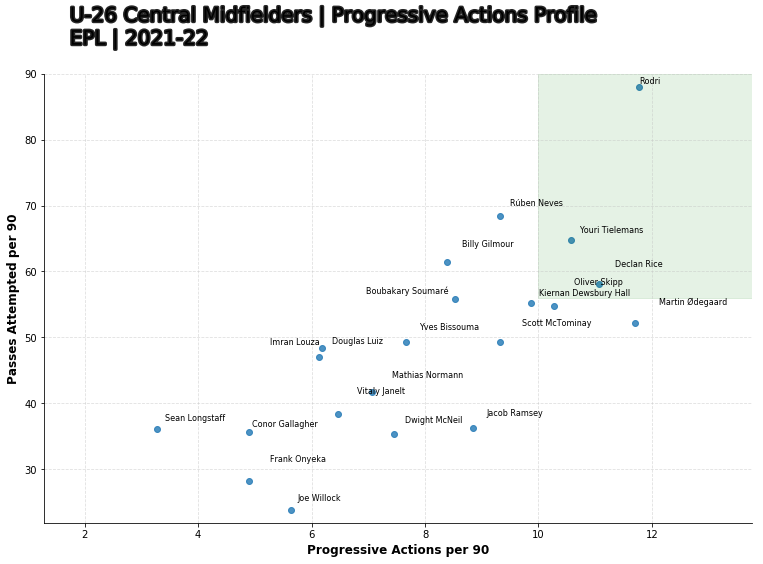

In [30]:
metrics_scatter_comparison(df, max_age, position)

In [31]:
scout_links = list(subset_of_data.scouting_url.unique())

In [32]:
def generate_advanced_data(scout_links):
    appended_data_per90 = []
    appended_data_percent = []
    for x in scout_links:
        warnings.filterwarnings("ignore")
        url = x
        page =requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        name = [element.text for element in soup.find_all("span")]
        name = name[7]
        html_content = requests.get(url).text.replace('<!--', '').replace('-->', '')
        df = pd.read_html(html_content)
        df[0].columns = df[0].columns.droplevel(0) # drop top header row
        stats = df[0]
        advanced_stats = stats.loc[(stats['Statistic'] != "Statistic" ) & (stats['Statistic'] != ' ')]
        advanced_stats = advanced_stats.dropna(subset=['Statistic',"Per 90", "Percentile"])
        per_90_df = advanced_stats[['Statistic',"Per 90",]].set_index("Statistic").T
        per_90_df["Name"] = name
        percentile_df = advanced_stats[['Statistic',"Percentile",]].set_index("Statistic").T
        percentile_df["Name"] = name
        appended_data_per90.append(per_90_df)
    appended_data_per90 = pd.concat(appended_data_per90)
    appended_data_per90 = appended_data_per90.reset_index(drop=True)
    del appended_data_per90.columns.name
    appended_data_per90 = appended_data_per90[['Name'] + [col for col in appended_data_per90.columns if col != 'Name']]
    appended_data_per90 = appended_data_per90.loc[:,~appended_data_per90.columns.duplicated()]
    return appended_data_per90



In [33]:
appended_data_per90 = generate_advanced_data(scout_links)

In [41]:
attacking = ["Name",'Goals', 'Assists', 'Non-Penalty Goals','Penalty Kicks Attempted', 'xG',
      'xA', 'npxG+xA', 'Shots Total', 'Shots on target', 'npxG/Sh',
       'Goals - xG', 'Non-Penalty Goals - npxG']
passing = ["Name", 'Passes Completed','Passes Attempted', 'Pass Completion %', 'Total Passing Distance',
       'Progressive Passing Distance', 'Passes Completed (Short)',
       'Passes Attempted (Short)', 'Pass Completion % (Short)',
       'Passes Completed (Medium)', 'Passes Attempted (Medium)',
       'Pass Completion % (Medium)', 'Passes Completed (Long)',
       'Passes Attempted (Long)', 'Pass Completion % (Long)',
       'Key Passes', 'Passes into Final Third',
       'Passes into Penalty Area', 'Crosses into Penalty Area',
       'Progressive Passes']
pass_types = ["Name", 'Live-ball passes', 'Dead-ball passes',
       'Passes from Free Kicks', 'Through Balls', 'Passes Under Pressure',
       'Switches', 'Crosses', 'Corner Kicks', 'Inswinging Corner Kicks',
       'Outswinging Corner Kicks', 'Straight Corner Kicks',
       'Ground passes', 'Low Passes', 'High Passes',
       'Passes Attempted (Left)', 'Passes Attempted (Right)',
       'Passes Attempted (Head)', 'Throw-Ins taken',
       'Passes Attempted (Other)', 'Passes Offside',
       'Passes Out of Bounds', 'Passes Intercepted', 'Passes Blocked']
chance_creation = ["Name",'Shot-Creating Actions', 'SCA (PassLive)', 'SCA (PassDead)',
       'SCA (Drib)', 'SCA (Sh)', 'SCA (Fld)', 'SCA (Def)',
       'Goal-Creating Actions', 'GCA (PassLive)', 'GCA (PassDead)',
       'GCA (Drib)', 'GCA (Sh)', 'GCA (Fld)', 'GCA (Def)']
defending = [ "Name", 'Tackles',
       'Tackles Won', 'Tackles (Def 3rd)', 'Tackles (Mid 3rd)',
       'Tackles (Att 3rd)', 'Dribblers Tackled', 'Dribbles Contested', 'Dribbled Past', 'Pressures',
       'Successful Pressures', 'Successful Pressure %',
       'Pressures (Def 3rd)', 'Pressures (Mid 3rd)',
       'Pressures (Att 3rd)', 'Blocks', 'Shots Blocked', 'Shots Saved',
       'Interceptions', 'Tkl+Int', 'Clearances', 'Errors','Ball Recoveries',
       'Aerials won', 'Aerials lost']
possesion = ["Name", 'Touches',
       'Touches (Def Pen)', 'Touches (Def 3rd)', 'Touches (Mid 3rd)',
       'Touches (Att 3rd)', 'Touches (Att Pen)', 'Touches (Live-Ball)',
       'Dribbles Completed', 'Dribbles Attempted', 'Successful Dribble %',
       'Players Dribbled Past', 'Nutmegs', 'Carries',
       'Total Carrying Distance', 'Progressive Carrying Distance',
       'Progressive Carries', 'Carries into Final Third',
       'Carries into Penalty Area', 'Miscontrols', 'Dispossessed',
       'Pass Targets', 'Passes Received', 'Passes Received %',
       'Progressive Passes Rec']
dicipline = ["Name", 'Yellow Cards', 'Red Cards','Second Yellow Card', 'Fouls Committed','Offsides','Penalty Kicks Conceded', 'Own Goals']
smarts = ["Name",'Penalty Kicks Won','Fouls Drawn']


In [81]:
per_90_dataframe = appended_data_per90[attacking]
per_90_dataframe

,Name,Goals,Assists,Non-Penalty Goals,Penalty Kicks Attempted,xG,xA,npxG+xA,Shots Total,Shots on target,npxG/Sh,Goals - xG,Non-Penalty Goals - npxG
0,Oliver Skipp,0.00,0.00,0.00,0.00,0.01,0.06,0.07,0.27,0.07,0.05,-0.01,-0.01
1,Vitaly Janelt,0.10,0.00,0.10,0.00,0.10,0.08,0.18,1.11,0.45,0.09,0.00,0.00
2,Frank Onyeka,0.00,0.00,0.00,0.00,0.09,0.02,0.11,1.38,0.43,0.07,-0.09,-0.09
3,Martin Ødegaard,0.19,0.19,0.19,0.00,0.13,0.23,0.37,1.35,0.49,0.10,+0.05,+0.05
4,Declan Rice,0.11,0.11,0.11,0.03,0.08,0.06,0.12,0.73,0.22,0.08,+0.03,+0.05
5,Scott McTominay,0.03,0.06,0.03,0.00,0.07,0.06,0.13,1.08,0.23,0.06,-0.04,-0.04
6,Billy Gilmour,0.00,0.05,0.00,0.00,0.04,0.12,0.15,0.71,0.11,0.06,-0.04,-0.04
7,Mathias Normann,0.08,0.08,0.08,0.00,0.07,0.03,0.10,1.60,0.42,0.04,+0.02,+0.02
8,Douglas Luiz,0.03,0.10,0.03,0.00,0.05,0.08,0.13,0.79,0.23,0.06,-0.02,-0.02
9,Jacob Ramsey,0.25,0.04,0.25,0.00,0.14,0.08,0.22,1.41,0.37,0.10,+0.11,+0.11


In [82]:
names = ["Youri Tielemans","Martin Ødegaard"]
per_90_dataframe = per_90_dataframe[per_90_dataframe.Name.isin(names)]
per_90_dataframe

,Name,Goals,Assists,Non-Penalty Goals,Penalty Kicks Attempted,xG,xA,npxG+xA,Shots Total,Shots on target,npxG/Sh,Goals - xG,Non-Penalty Goals - npxG
3,Martin Ødegaard,0.19,0.19,0.19,0.00,0.13,0.23,0.37,1.35,0.49,0.10,+0.05,+0.05
15,Youri Tielemans,0.18,0.12,0.12,0.06,0.16,0.15,0.27,1.90,0.51,0.06,+0.02,0.00


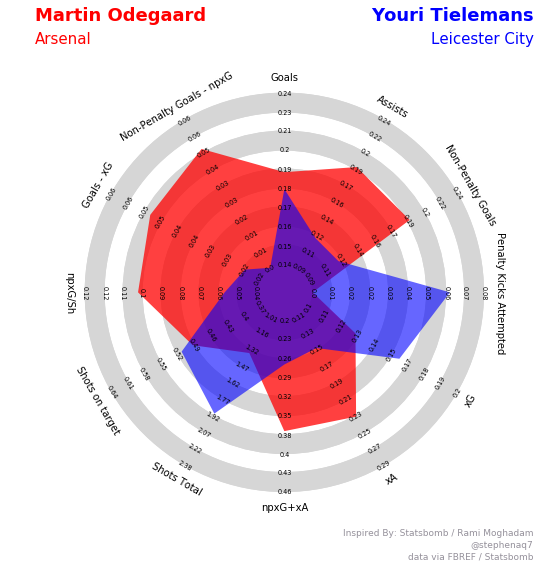

In [92]:
player_names = ["Youri Tielemans","Martin Odegaard"]
per_90_dataframe.reset_index(drop=True)
per_90_dataframe = per_90_dataframe[per_90_dataframe.Name.isin(names)]
cols = per_90_dataframe.columns.drop('Name')
per_90_dataframe[cols] = per_90_dataframe[cols].apply(pd.to_numeric)
params = list(per_90_dataframe.columns)
params = params[1:]
params

ranges = []
a_values = []
b_values = []

for x in params:
    a = min(per_90_dataframe[params][x])
    a = a - (a* 0.25)
    
    b = max(per_90_dataframe[params][x])
    b = b + (b* 0.25)
    
    ranges.append((a,b))
    
a_values = per_90_dataframe.iloc[0].values.tolist()

b_values = per_90_dataframe.iloc[1].values.tolist()
        
a_values = a_values[1:]
b_values = b_values[1:]

values = [a_values,b_values]

get_clubs = subset_of_data[subset_of_data.Player.isin(player_names)]
link_list = list(get_clubs.urls.unique())
title_vars = []
for x in link_list:     
    warnings.filterwarnings("ignore")
    html_content = requests.get(x).text.replace('<!--', '').replace('-->', '')
    df2 = pd.read_html(html_content)
    df2[5].columns = df2[5].columns.droplevel(0) 
    stats2 = df2[5]
    key_vars = stats2[["Season","Age","Squad"]]
    key_vars = key_vars[key_vars.Season.isin(["2021-2022"])]
    title_vars.append(key_vars)
title_vars = pd.concat(title_vars)
ages = list(title_vars.Age.unique())
teams = list(title_vars.Squad.unique())

#title 

title = dict(
    title_name= player_names[1],
    title_color = 'red',
    subtitle_name = teams[0],
    subtitle_color = 'red',

    title_name_2= player_names[0],
    title_color_2 = 'blue',
    subtitle_name_2 = teams[1],
    subtitle_color_2 = 'blue',
    title_fontsize = 18,
    subtitle_fontsize=15
)

endnote = '@stephenaq7\ndata via FBREF / Statsbomb'

radar = Radar()

fig,ax = radar.plot_radar(ranges=ranges,params=params,values=values,
                         radar_color=['red','blue'],
                         alphas=[.75,.6],title=title,endnote=endnote,
                         compare=True)

In [91]:
title_vars

,Season,Age,Squad
8,2021-2022,22.0,Arsenal
9,2021-2022,24.0,Leicester City
